# Multi-Style Transfer with Deep Neural Networks

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.5.0
True


In [4]:
# import resources
%matplotlib inline

from PIL import *
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Load in VGG19 (features)

In [5]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [6]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load in Content and Style Images

In [8]:
from utils import load_image

# load in content and style image
content = load_image('content/janelle.jpg').to(device)

# Resize style to match content, makes code easier
style1 = load_image('style/delaunay.jpg', shape=content.shape[-2:]).to(device)
style2 = load_image('style/hockney.jpg', shape=content.shape[-2:]).to(device)

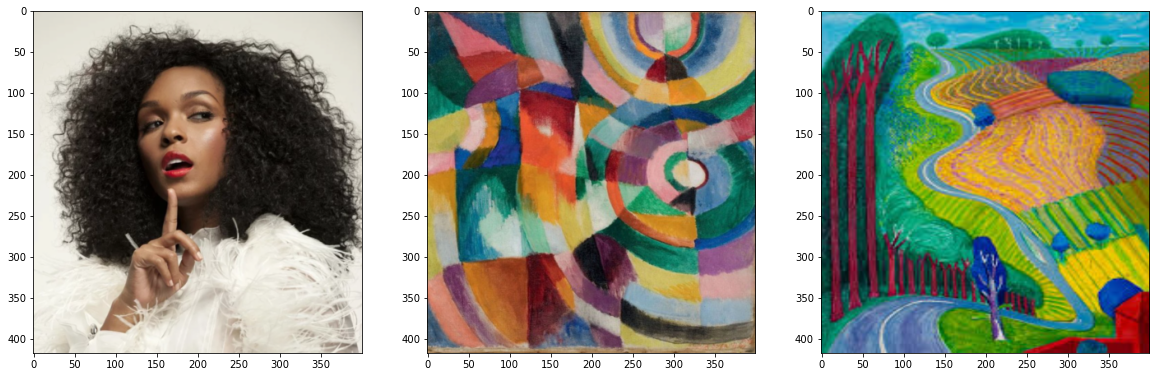

In [9]:
from utils import im_convert

# display the images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style1))
ax3.imshow(im_convert(style2))

---
## VGG19 Layers

To get the content and style representations of an image, we have to pass an image forward through the VGG19 network until we get to the desired layer(s) and then get the output from that layer.

In [10]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

In [11]:
def get_features(image, model, layers=None):

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## <-- content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

In [12]:
def gram_matrix(tensor):
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Putting it all Together

In [13]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features1 = get_features(style1, vgg)
style_features2 = get_features(style2, vgg)

# calculate the gram matrices for each layer of our style representation (conv1_1 to conv5_1)
style_grams1 = {layer: gram_matrix(style_features1[layer]) for layer in style_features1}
style_grams2 = {layer: gram_matrix(style_features2[layer]) for layer in style_features2}

# Define target image from content image
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

In [14]:
# weights for each style layer 
style_weights = {'conv1_1': 1.,
                 'conv2_1': 1,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

## Updating the Target & Calculating Losses

Total loss:  356622499840.0


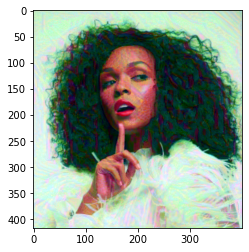

Total loss:  292616011776.0


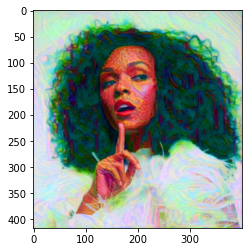

Total loss:  279500390400.0


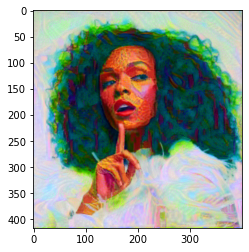

Total loss:  272876519424.0


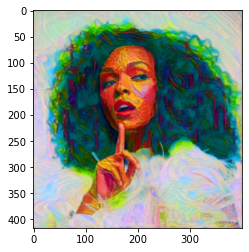

Total loss:  269170081792.0


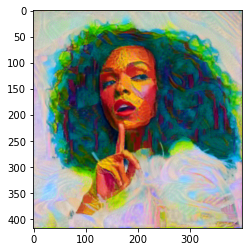

Total loss:  266963501056.0


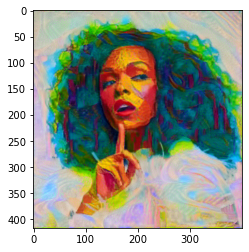

Total loss:  265600499712.0


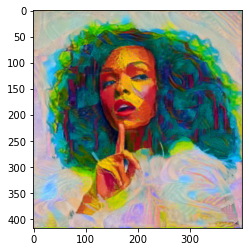

Total loss:  264748957696.0


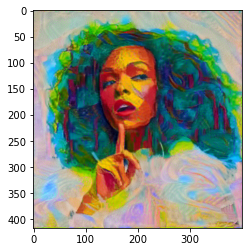

Total loss:  264220737536.0


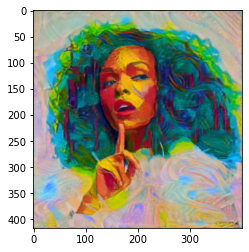

Total loss:  263893221376.0


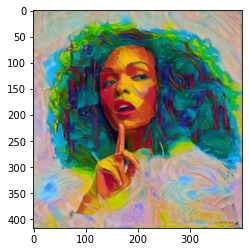

In [15]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 4000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram1 = style_grams1[layer]
        style_gram2 = style_grams2[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss1 = style_weights[layer] * torch.mean((target_gram - style_gram1)**2)
        layer_style_loss2 = style_weights[layer] * torch.mean((target_gram - style_gram2)**2)
        layer_style_loss = layer_style_loss1 + layer_style_loss2 
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

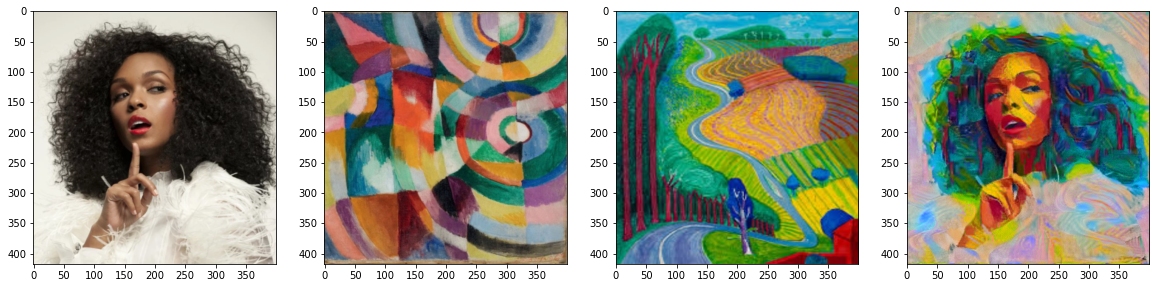

In [16]:
# display content and final, target image
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
# plt.axis('off')
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style1))
ax3.imshow(im_convert(style2))
ax4.imshow(im_convert(target))
plt.show()

## Save Image

In [ ]:
import os
if not os.path.exists("output"):
    os.makedirs("output")

In [17]:
plt.imsave("output/multi_target.jpg", im_convert(target))